In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#sql
%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:

In [2]:
data = pd.read_csv(r"data/fitbit_export_20230111.csv")

## Data Cleanup

Since the columns are defined as Activities, rather than Date, Calories Burned, etc. I need to redefine the columns.

In [3]:
data.columns

Index(['Activities'], dtype='object')

In [4]:
test_df = data.reset_index()
print(test_df.columns)

names = ['Date','CaloriesBurned','Steps', 'Distance', 'Floors', 'MinutesSedentary', \
                                        'MinutesLightlyActive', 'MinutesFairlyActive', 'MinutesVeryActive']
for i in range(9):
    test_df = test_df.rename(columns={f'level_{i}':names[i]})

test_df = test_df.rename(columns={'Activities':'ActivityCalories'})
test_df = test_df.drop(0)

Index(['level_0', 'level_1', 'level_2', 'level_3', 'level_4', 'level_5',
       'level_6', 'level_7', 'level_8', 'Activities'],
      dtype='object')


Now I will divide the Activity and Sleep data into 2 separate dataframes.

In [5]:
sleep_index = test_df[test_df["Date"] == "Sleep"].index[0]


#creating activity_df and sleep_df
activity_df = test_df[:sleep_index-1]
activity_df = activity_df.reset_index()
activity_df = activity_df.drop(columns=['index'])

sleep_df = test_df[sleep_index:]
sleep_df = sleep_df.drop(columns=['ActivityCalories'])
sleep_df = sleep_df.drop(sleep_df[sleep_df["Date"] == "Start Time"].index[0])

#rename columns
names = ['StartTime','EndTime','MinutesAsleep', 'MinutesAwake', 'NumAwakenings', 'MinutesInBed', \
                                        'MinutesREMSleep', 'MinutesLightSleep', 'MinutesDeepSleep']
sleep_df.columns = names

#reset index to start from 0
sleep_df = sleep_df.reset_index()
sleep_df = sleep_df.drop(columns=['index'])
sleep_df.head()

,StartTime,EndTime,MinutesAsleep,MinutesAwake,NumAwakenings,MinutesInBed,MinutesREMSleep,MinutesLightSleep,MinutesDeepSleep
0,2022-02-28 2:59AM,2022-02-28 9:36AM,355,42,34,397,37,263,55
1,2022-02-27 1:41AM,2022-02-27 8:43AM,360,61,30,421,90,202,68
2,2022-02-26 1:43AM,2022-02-26 9:15AM,386,66,28,452,111,191,84
3,2022-02-25 12:01AM,2022-02-25 7:25AM,387,57,25,444,99,218,70
4,2022-02-24 12:17AM,2022-02-24 7:45AM,393,55,31,448,109,214,70


## Automating data separation

In [7]:
def makeDF(data):
    activity = data.reset_index()

    names = ['Date','CaloriesBurned','Steps', 'Distance', 'Floors', 'MinutesSedentary', \
                                        'MinutesLightlyActive', 'MinutesFairlyActive', 'MinutesVeryActive']
    for i in range(9):
        activity = activity.rename(columns={f'level_{i}':names[i]})

    activity = activity.rename(columns={'Activities':'ActivityCalories'})
    activity = activity.drop(0)
    
    #creating activity_df and sleep_df
    sleep_index = activity[activity["Date"] == "Sleep"].index[0]    
    sleep = activity[sleep_index:]
    
    activity = activity[:sleep_index-1]
    activity = activity.reset_index()
    activity = activity.drop(columns=['index'])
    
    sleep = sleep.drop(columns=['ActivityCalories'])
    sleep = sleep.drop(sleep[sleep["Date"] == "Start Time"].index[0])

    #rename columns
    names = ['StartTime','EndTime','MinutesAsleep', 'MinutesAwake', 'NumAwakenings', 'MinutesInBed', \
                                        'MinutesREMSleep', 'MinutesLightSleep', 'MinutesDeepSleep']
    sleep.columns = names

    #reset index to start from 0
    sleep = sleep.reset_index()
    sleep = sleep.drop(columns=['index'])    
    
    return [activity, sleep]

In [8]:
for i in range(1,11):
    data = pd.read_csv(f'data/fitbit_export_20230111 ({i}).csv')
    activity, sleep = makeDF(data)
    activity_df = pd.concat([activity_df, activity], ignore_index=True)
    sleep_df = pd.concat([sleep_df, sleep], ignore_index=True)

In [9]:
print('sleep_df shape:', sleep_df.shape)
print('activity_df shape:', activity_df.shape)

sleep_df shape: (193, 9)
activity_df shape: (335, 10)


## Removing and Filling in Missing Data

After dividing my data into their respective data frames, I will now remove missing data from before and after the days I recorded data with my FitBit (i.e. I lost my FitBit after March 4th, 2022 so I shouldn't have any data from after!)

In [10]:
#create date time object for easier data sorting
activity_df['Date'] = pd.to_datetime(activity_df['Date'])

In [11]:
%sql SELECT * FROM activity_df WHERE Date >= '2022-03-03'

,Date,CaloriesBurned,Steps,Distance,Floors,MinutesSedentary,MinutesLightlyActive,MinutesFairlyActive,MinutesVeryActive,ActivityCalories
0,2022-03-03,"2,348","21,829",9.27,92,652,266,45,72,"1,426"
1,2022-03-04,"1,900","15,096",6.25,70,747,166,19,45,870
2,2022-03-05,"1,193",0,0,0,"1,440",0,0,0,0
3,2022-03-06,"1,193",0,0,0,"1,440",0,0,0,0
4,2022-03-07,"1,193",0,0,0,"1,440",0,0,0,0
5,2022-03-08,"1,193",0,0,0,"1,440",0,0,0,0
6,2022-03-09,"1,193",0,0,0,"1,440",0,0,0,0
7,2022-03-10,"1,193",0,0,0,"1,440",0,0,0,0
8,2022-03-11,"1,193",0,0,0,"1,440",0,0,0,0
9,2022-03-12,"1,193",0,0,0,"1,440",0,0,0,0


In [12]:
%sql activity_df << SELECT * FROM activity_df WHERE Date < '2022-03-05'

Returning data to local variable activity_df


In [13]:
#converting all 'object' date types to numeric data type
activity_df['CaloriesBurned'] = activity_df['CaloriesBurned'].str.replace(',', '').astype(int)
activity_df['MinutesSedentary'] = activity_df['MinutesSedentary'].str.replace(',', '').astype(int)
activity_df['ActivityCalories'] = activity_df['ActivityCalories'].str.replace(',', '').astype(int)
activity_df['Steps'] = activity_df['Steps'].str.replace(',', '').astype(int)
activity_df['Distance'] = activity_df['Distance'].astype(float)

In [14]:
sleep_df['StartTime'] = pd.to_datetime(sleep_df['StartTime'])
sleep_df['EndTime'] = pd.to_datetime(sleep_df['EndTime'])

In [15]:
sleep_df.iloc[:,2:] = sleep_df.iloc[:,2:].apply(pd.to_numeric)

## Data Limitations

The sleep data has significantly less rows because it records sleep data from the night of till morning of the next day. However, the data is not a perfectly recorded in 335/2 rows because I did not always sleep before 12 AM, thus recording only 1 day of data. I also did not wear my FitBit to sleep every night.

## Data Exploration

In [16]:
act_yr = activity_df['Date'].dt.year
act_m = activity_df['Date'].dt.month
activity_avgs = activity_df.groupby([act_yr, act_m]).mean()
dates = [f'{yr}-{m}' for yr,m in activity_avgs.index]

### Exploratory Question: Does more steps mean more calories burned?

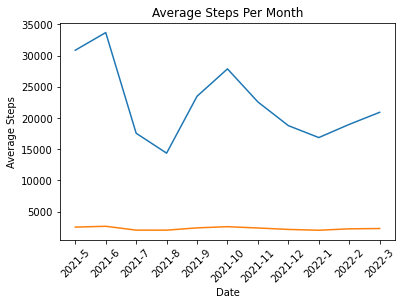

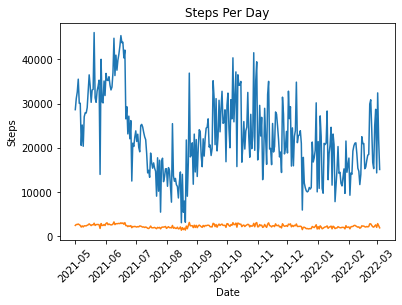

In [17]:
# month vs avg steps
sns.lineplot(data=activity_avgs, x=dates, y="Steps")
sns.lineplot(data=activity_avgs, x=dates, y="CaloriesBurned")
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Average Steps")
plt.title("Average Steps Per Month")
plt.show()

# all dates vs all steps
sns.lineplot(data=activity_df, x='Date', y="Steps")
sns.lineplot(data=activity_df, x='Date', y="CaloriesBurned")
plt.xticks(rotation=45)
plt.title("Steps Per Day")
plt.show()

## Better Visualizations of Steps and Calories Burned

For better visualization of the relationship between the two fields CaloriesBurned and Steps, we can plot them together.

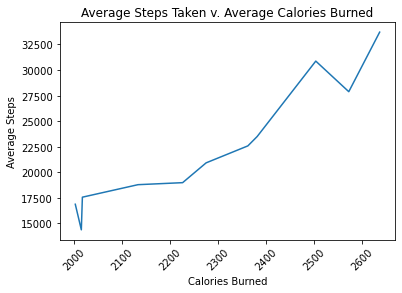

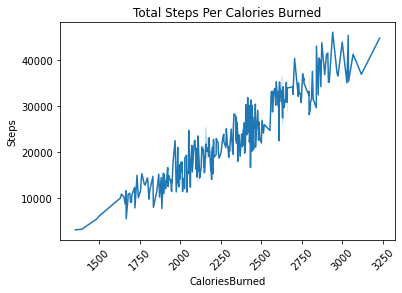

In [22]:
# avg steps vs avg calories burned
sns.lineplot(data=activity_avgs, x="CaloriesBurned", y="Steps")
plt.xticks(rotation=45)
plt.xlabel("Calories Burned")
plt.ylabel("Average Steps")
plt.title("Average Steps Taken v. Average Calories Burned")
plt.show()

# steps vs calories burned
sns.lineplot(data=activity_df, x='CaloriesBurned', y="Steps")
plt.xticks(rotation=45)
plt.title("Total Steps Per Calories Burned")
plt.show()

<AxesSubplot:xlabel='CaloriesBurned', ylabel='Steps'>

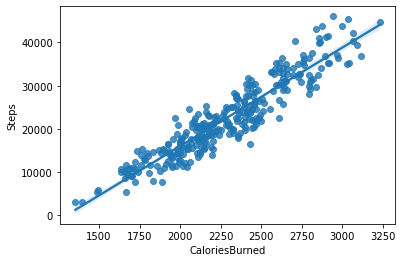

In [17]:
sns.regplot(data = activity_df, x = "CaloriesBurned", y = "Steps")

By observing the regression plot, I can see that the confidence interval surrounding the regression line is small, meaning that their is stong evidence supporting the idea that there is a positive correlation between steps and calories burned.

In [18]:
activity_df.corr()

,CaloriesBurned,Steps,Distance,MinutesSedentary,ActivityCalories
CaloriesBurned,1.000000,0.932225,0.890391,-0.275387,0.995795
Steps,0.932225,1.000000,0.979167,-0.046709,0.914964
Distance,0.890391,0.979167,1.000000,0.002305,0.862574
MinutesSedentary,-0.275387,-0.046709,0.002305,1.000000,-0.313824
ActivityCalories,0.995795,0.914964,0.862574,-0.313824,1.000000


In [24]:
activity_df['DayofWeek'] = pd.to_datetime(activity_df['Date']).dt.dayofweek

### Exploratory Question: Is there a relationship between the day of the week and how sedentary I am?

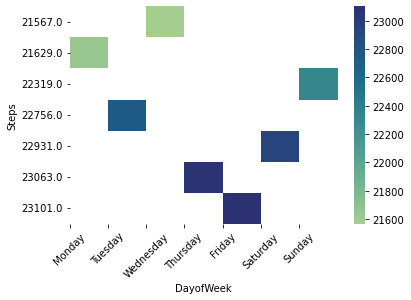

In [43]:
week_activity = activity_df.groupby('DayofWeek').mean().round()
week_activity = week_activity.reset_index()
table1 = week_activity.pivot('Steps','DayofWeek','Steps')
hmap = sns.heatmap(table1, cmap="crest")
hmap.set_xticks(range(7), ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.xticks(rotation=45)
plt.show()

With the heatmap, I can see that I am less sedentary/get more steps in the day later in the week.

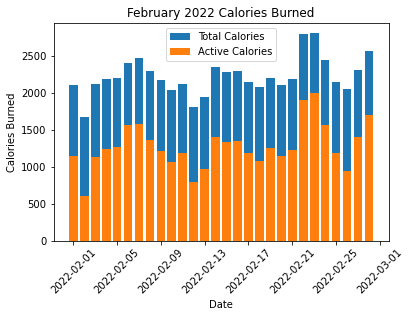

In [45]:
plt.bar(data=activity_df[:28], x='Date', height="CaloriesBurned")
plt.bar(data=activity_df[:28], x='Date', height="ActivityCalories")
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Calories Burned")
plt.legend(["Total Calories", "Active Calories"])
plt.title("February 2022 Calories Burned")
plt.show()

### Exploratory Question: Do I get more sleep during school breaks?

In [46]:
sleep_df['StartTime'] = pd.to_datetime(sleep_df['StartTime'])
sleep_df['EndTime'] = pd.to_datetime(sleep_df['EndTime'])
sleep_df['TotalSleep'] = sleep_df['EndTime'] - sleep_df['StartTime']
sleep_df['StartDate'] = sleep_df['StartTime'].dt.date
sleep_df.head()

,StartTime,EndTime,MinutesAsleep,MinutesAwake,NumAwakenings,MinutesInBed,MinutesREMSleep,MinutesLightSleep,MinutesDeepSleep,TotalSleep,StartDate
0,2022-02-28 02:59:00,2022-02-28 09:36:00,355,42,34,397,37.0,263.0,55.0,0 days 06:37:00,2022-02-28
1,2022-02-27 01:41:00,2022-02-27 08:43:00,360,61,30,421,90.0,202.0,68.0,0 days 07:02:00,2022-02-27
2,2022-02-26 01:43:00,2022-02-26 09:15:00,386,66,28,452,111.0,191.0,84.0,0 days 07:32:00,2022-02-26
3,2022-02-25 00:01:00,2022-02-25 07:25:00,387,57,25,444,99.0,218.0,70.0,0 days 07:24:00,2022-02-25
4,2022-02-24 00:17:00,2022-02-24 07:45:00,393,55,31,448,109.0,214.0,70.0,0 days 07:28:00,2022-02-24


In [47]:
#total minutes of sleep
sleep_df['TotalSleep']= sleep_df['TotalSleep'].dt.total_seconds()/60

In [48]:
sleep_df['DayofWeek'] = pd.to_datetime(sleep_df['StartDate']).dt.dayofweek

Note: For a more in depth analysis, I would fill in the time gaps with NaNs for a more accurate visualization. I did not in this case for time reasons.

In [49]:
# Fall Semester: August 26th, 2021 - December 18th, 2021
fallStart = sleep_df[sleep_df["StartDate"] == pd.to_datetime("2021-08-27")].index[0]
fallEnd = sleep_df[sleep_df["StartDate"] == pd.to_datetime("2021-12-18")].index[0]

fall_df = sleep_df.iloc[fallEnd:fallStart]

# Winter Break: Decemer 19th, 2021 - January 23st, 2022
winterStart = sleep_df[sleep_df["StartDate"] == pd.to_datetime("2021-12-20")].index[0]
winterEnd = sleep_df[sleep_df["StartDate"] == pd.to_datetime("2022-01-23")].index[0]

winter_df = sleep_df.iloc[winterEnd:winterStart]

C:\ProgramData\Anaconda3\envs\info2950\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


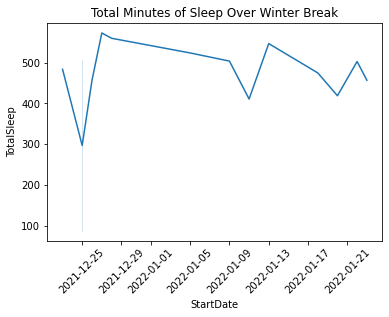

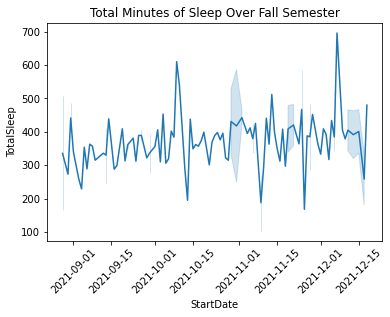

In [50]:
sns.lineplot(data=winter_df, x='StartDate', y='TotalSleep')
plt.xticks(rotation=45)
plt.title("Total Minutes of Sleep Over Winter Break")
plt.show()

sns.lineplot(data=fall_df, x='StartDate', y='TotalSleep')
plt.xticks(rotation=45)
plt.title("Total Minutes of Sleep Over Fall Semester")
plt.show()

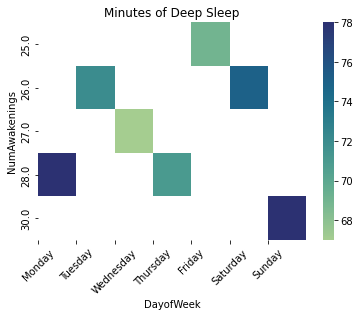

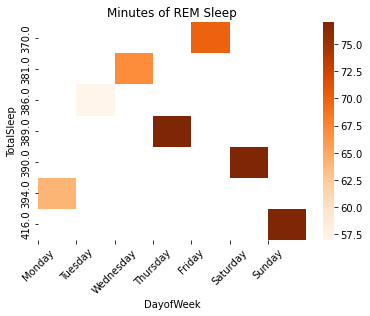

In [64]:
week_activity_sleep = sleep_df.groupby('DayofWeek').mean().round()
week_activity_sleep = week_activity_sleep.reset_index()
table2 = week_activity_sleep.pivot('NumAwakenings','DayofWeek','MinutesDeepSleep')
hmap1 = sns.heatmap(table2, cmap="crest")
hmap1.set_xticks(range(7), ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.xticks(rotation=45)
plt.title("Minutes of Deep Sleep")
plt.show()


table3 = week_activity_sleep.pivot('TotalSleep','DayofWeek','MinutesREMSleep')
hmap2 = sns.heatmap(table3, cmap="Oranges")
hmap2.set_xticks(range(7), ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.xticks(rotation=45)
plt.title("Minutes of REM Sleep")
plt.show()


The graph suggests that I get more deep sleep and REM sleep later in the week (i.e. Thursday - Sunday).